In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# data = 'drive/My Drive/train_data.csv'

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable

## Function that returns train,validation and test dataloader 

In [6]:
def load_train_dataset():
    train_df = pd.read_csv("/content/drive/My Drive/train_data.csv")
    
    #get the pixels in one variable and the target or label in another variable for classification problem
    X = np.array(train_df.loc[:, train_df.columns != 'Label'].values)/255
    # X = sc.fit_transform(X)
    y = np.array(train_df['Label'].values)

    
    #split the data into train and validation set. 80% for training and rest for validation
    features_train, features_val, targets_train, targets_val = train_test_split(X,y,test_size=0.2)
    X_train = torch.from_numpy(features_train).type(torch.float)
    X_val = torch.from_numpy(features_val).type(torch.float)

    Y_train = torch.from_numpy(targets_train)
    Y_val = torch.from_numpy(targets_val)


    train = torch.utils.data.TensorDataset(X_train,Y_train)
    val = torch.utils.data.TensorDataset(X_val,Y_val)


    train_loader = torch.utils.data.DataLoader(train,shuffle=False,batch_size = 20)
    val_loader = torch.utils.data.DataLoader(val,shuffle=False,batch_size = 20)
       
    
    return train_loader,val_loader
   

def load_test_dataset():

    test_df = pd.read_csv("/content/drive/My Drive/test_data.csv")
    
    X = np.array(test_df.loc[:, test_df.columns != 'character'].values)/255
    # sc.fit_transform(X)
    y = np.array(test_df['character'].values)
    
    X = torch.from_numpy(X).type(torch.float)
    y = torch.from_numpy(y)
    test = torch.utils.data.TensorDataset(X,y)
    
    test_loader = torch.utils.data.DataLoader(test,shuffle=True,batch_size = 20)
    
    return test_loader

    

    

    

In [7]:

train_loader,valid_loader=load_train_dataset()

In [8]:
test_loader = load_test_dataset()

In [9]:
len(train_loader)

2448

## Character Mapping Function 

In [10]:
def map_labels(label):
    charset = {
                0:"Not a Nepali Char",
                1: 'क',
                2: 'ख',
                3: 'ग',
                4: 'घ',
                5: 'ङ',
                6: 'च',
                7: 'छ',
                8: 'ज',
                9: 'झ',
                10: 'ञ',
                11: 'ट',
                12: 'ठ',
                13: 'ड',
                14: 'ढ',
                15: 'ण',
                16: 'त',
                17: 'थ',
                18: 'द',
                19: 'ध',
                20: 'न',
                21: 'प',
                22: 'फ',
                23: 'ब',
                24: 'भ',
                25: 'म',
                26: 'य',
                27: 'र',
                28: 'ल',
                29: 'व',
                30: 'श',
                31: 'ष',
                32: 'स',
                33: 'ह',
                34: 'क्ष,',
                35: 'त्र',
                36: 'ज्ञ',
        
    }
    for key,value in charset.items():
        if label==key:
            return value
    

## Visualize the data 

In [11]:
%matplotlib inline
def data_visualize_before_pred(loader):
    """
    function that visualizes images before and after training.
    
    Arguments:  
    
    loader - data loader for PyTorch (can ne train,test or validation loader)
    """
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.numpy()
   
    csfont = {'fontname':'Nirmala UI'}
    # obtain one batch of training images
   

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(30, 6))
    for ind in range(20):
        ax = fig.add_subplot(2, 20/2, ind+1, xticks=[], yticks=[])
        images = images.reshape(-1,32,32)
        ax.imshow(np.squeeze(images[ind]), cmap='gray')
        a = map_labels(labels[ind])
        ax.set_title(a,**csfont,fontsize=25)
    

findfont: Font family ['Nirmala UI'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2358 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2337 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2337 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214

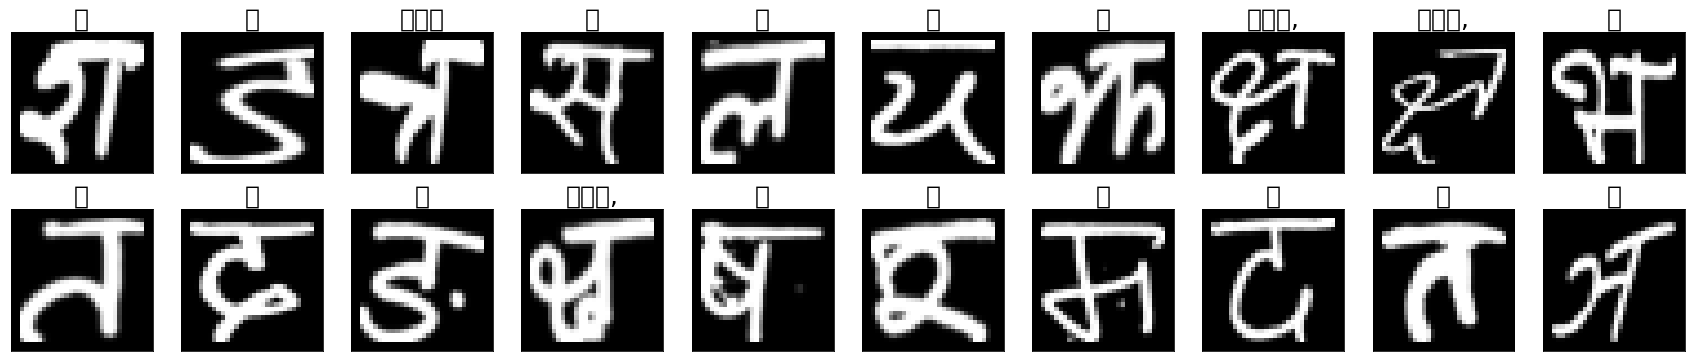

In [12]:
data_visualize_before_pred(test_loader)

In [13]:
from torch.nn import Module
from torch import nn
import torch.nn.functional as F

class ResNet(nn.Module):
    
    def __init__(self, n=7, res_option='A', use_dropout=False):
        super(ResNet, self).__init__()
        self.res_option = res_option
        self.use_dropout = use_dropout
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(5)
        self.relu1 = nn.ReLU(inplace=True)
        self.layers1 = self._make_layer(n, 5, 5, 1)
        self.layers2 = self._make_layer(n, 10, 5, 2)
        self.layers3 = self._make_layer(n, 20, 10, 2)
        self.avgpool = nn.AvgPool2d(8)
        self.linear = nn.Linear(20, 37)
    
    def _make_layer(self, layer_count, channels, channels_in, stride):
        return nn.Sequential(
            ResBlock(channels, channels_in, stride, res_option=self.res_option, use_dropout=self.use_dropout),
            *[ResBlock(channels) for _ in range(layer_count-1)])
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.layers1(out)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class ResBlock(nn.Module):
    
    def __init__(self, num_filters, channels_in=None, stride=1, res_option='A', use_dropout=False):
        super(ResBlock, self).__init__()
        
        # uses 1x1 convolutions for downsampling
        if not channels_in or channels_in == num_filters:
            channels_in = num_filters
            self.projection = None
        else:
            if res_option == 'A':
                self.projection = IdentityPadding(num_filters, channels_in, stride)
            elif res_option == 'B':
                self.projection = ConvProjection(num_filters, channels_in, stride)
            elif res_option == 'C':
                self.projection = AvgPoolPadding(num_filters, channels_in, stride)
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(channels_in, num_filters, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)
        if self.use_dropout:
            self.dropout = nn.Dropout(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_dropout:
            out = self.dropout(out)
        if self.projection:
            residual = self.projection(x)
        out += residual
        out = self.relu2(out)
        return out


# various projection options to change number of filters in residual connection
# option A from paper
class IdentityPadding(nn.Module):
    def __init__(self, num_filters, channels_in, stride):
        super(IdentityPadding, self).__init__()
        # with kernel_size=1, max pooling is equivalent to identity mapping with stride
        self.identity = nn.MaxPool2d(1, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out

# option B from paper
class ConvProjection(nn.Module):

    def __init__(self, num_filters, channels_in, stride):
        super(ResA, self).__init__()
        self.conv = nn.Conv2d(channels_in, num_filters, kernel_size=1, stride=stride)
    
    def forward(self, x):
        out = self.conv(x)
        return out

# experimental option C
class AvgPoolPadding(nn.Module):

    def __init__(self, num_filters, channels_in, stride):
        super(AvgPoolPadding, self).__init__()
        self.identity = nn.AvgPool2d(stride, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out
    

In [15]:

model = ResNet()
model = model.float()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.7)
print(model)

ResNet(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (layers1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(5, eps=1e

In [16]:
def train_model(n_epochs):
  train_losses = []
  val_losses = []

# initialize tracker for minimum validation loss
  valid_loss_min = np.Inf # set initial "min" to infinity

  for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        data = Variable(data.view(-1,1,32,32))
        target=Variable(target)
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        data = Variable(data.view(-1,1,32,32))
        target=Variable(target)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model,'/content/drive/My Drive/Models/res.pt')
        valid_loss_min = valid_loss
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.show()

        


Epoch: 1 	Training Loss: 0.823829 	Validation Loss: 0.181818
Validation loss decreased (inf --> 0.181818).  Saving model ...
Epoch: 2 	Training Loss: 0.182861 	Validation Loss: 0.158595
Validation loss decreased (0.181818 --> 0.158595).  Saving model ...
Epoch: 3 	Training Loss: 0.117495 	Validation Loss: 0.093470
Validation loss decreased (0.158595 --> 0.093470).  Saving model ...
Epoch: 4 	Training Loss: 0.083246 	Validation Loss: 0.082239
Validation loss decreased (0.093470 --> 0.082239).  Saving model ...
Epoch: 5 	Training Loss: 0.065509 	Validation Loss: 0.082315
Epoch: 6 	Training Loss: 0.052094 	Validation Loss: 0.065168
Validation loss decreased (0.082239 --> 0.065168).  Saving model ...
Epoch: 7 	Training Loss: 0.043192 	Validation Loss: 0.064365
Validation loss decreased (0.065168 --> 0.064365).  Saving model ...
Epoch: 8 	Training Loss: 0.033762 	Validation Loss: 0.069711
Epoch: 9 	Training Loss: 0.031892 	Validation Loss: 0.073301
Epoch: 10 	Training Loss: 0.026689 	Valida

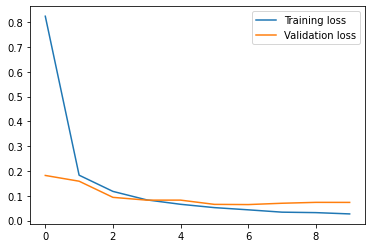

In [17]:
# defining the number of epochs

train_model(10)



## To view  the entire model saved

In [14]:
model_loaded = torch.load('/content/drive/My Drive/Models/res.pt')

## Test the model using a test set of data 

In [15]:
def evaluate(data_loader):
    """
     A function used to calculate the accuracy, total number of images tested.

     Arguments: 
  
     data_loader -- a pytorch data loader (can be train_loader, test_loader or validation_loader)
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images = images.view(-1,1,32,32)
            outputs = model_loaded(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Total images tested:', total)
    print('Total correct:', correct)
    accuracy = correct/total * 100
    print('Accuracy of model is {:.4f} %'.format(accuracy))

In [16]:
print("Result on Train data")
evaluate(train_loader)

Result on Train data
Total images tested: 48960
Total correct: 48421
Accuracy of model is 98.8991 %


In [17]:
print("Result on Validataion data")
evaluate(valid_loader)

Result on Validataion data
Total images tested: 12240
Total correct: 12087
Accuracy of model is 98.7500 %


In [18]:
print("Result on Test data")
evaluate(test_loader)

Result on Test data
Total images tested: 10800
Total correct: 10597
Accuracy of model is 98.1204 %


In [21]:
def data_visualize_after_pred(loader):
    """
    function that visualizes images after training. The image with green labels are correctly classified and red labels are misclassified.
    
    Arguments:  
    
    loader - data loader for PyTorch (can ne train,test or validation loader)
    """
    dataiter = iter(loader)
    images, labels = dataiter.next()
    images = images.view(-1,1,32,32)
    
   
    csfont = {'fontname':'Nirmala UI'}

# get sample outputs
    output = model_loaded(images)
# convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
# prep images for display
    images = images.numpy()
    

# plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 6))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(map_labels(preds[idx].item()), map_labels(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"),**csfont,fontsize = 25)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2335 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2335 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2359 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 

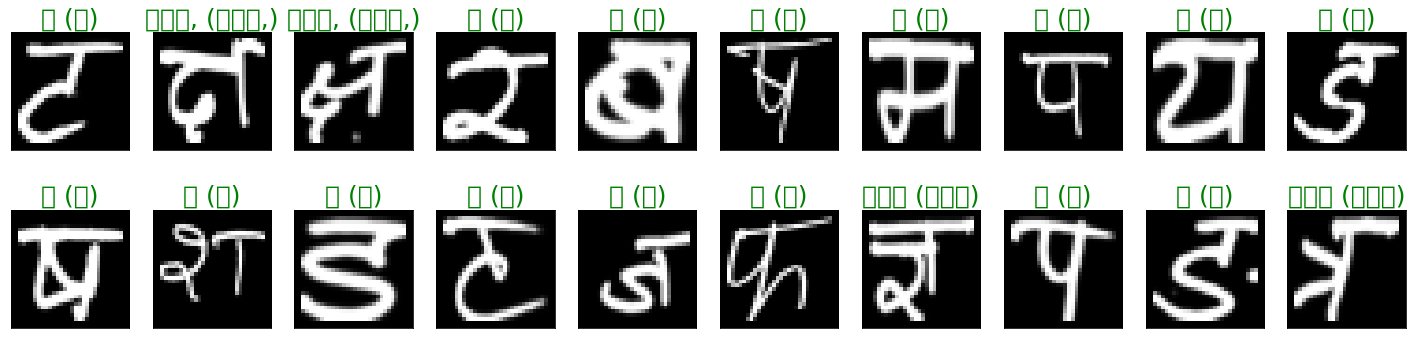

In [22]:
data_visualize_after_pred(test_loader)

In [27]:
def test_model(img_name):
  """
  A function that returns the character present in image selected

  Arguments :
  img_name -- Name of image to test
  """

    # defining the image path
  image_path = '/content/drive/My Drive/' + str(img_name) + '.png'
    # reading the image
  img = imread(image_path, as_gray=True)
    # normalizing the pixel values
  img = img/255
    # converting the type of pixel to float 32
  img = img.astype('float32')
    # appending the image into the list

# converting the list to numpy array
  test_x = np.array(img)
  print("The image you selected is :")
  plt.imshow(np.squeeze(test_x),cmap='gray')
  test_x = test_x.reshape(1, 32, 32)
  test_x  = torch.from_numpy(test_x)  
  
  with torch.no_grad():
    output = model_loaded(test_x.view(1,1,32,32))

  softmax = torch.exp(output)
  prob = list(softmax.numpy())
  predictions = np.argmax(prob, axis=1)
  print("The image contains {} character".format(map_labels(predictions)))
    
  


The image you selected is :
The image contains क character


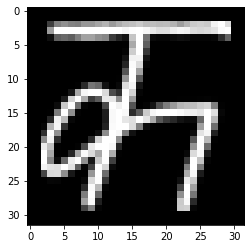

In [28]:
test_model(1342)
